# ROC and Distribution Analysis - Lower level classifications (Family to Phylum)

## Overview
This notebook modifies output CSV files generated by the Naive Bayes Classifier (NBC) for lower-level classifications. Taxonomic levels that were tested are Family, Order, Class and Phylum.


## Prerequisites

- Concatenate files before exporting. For eg. `trial_01_max_1.csv` and `trial_01_max_450001.csv`can be combined into a single `trial_01.csv` file using `cat`.
- Ensure all relevant NBC output CSV files are available locally. 


## Important Notes
- All output will be saved to your local environment.
- Do not use this notebook for superkingdom classifications. This is only for lower level classifications (Family to Phylum).

## Imports

In [ ]:
import os
from pathlib import Path
import pandas as pd
import json
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import re
import numpy as np
from sklearn.metrics import roc_curve, auc

## Functions

In [ ]:
def training_lists(taxa, trial):
    with open(f'/path/{taxa}/{taxa}_{trial}_training_list.txt', 'r') as t:
        lines = t.readlines()
        lines = [line.strip('\n') for line in lines] 
        return lines
    
# example usage

trial_map = {
    '01': [],
    '02': [],
    '03': [],
    '04': [],
    '05': []
}

for trial in ['trial_01', 'trial_02', 'trial_03', 'trial_04', 'trial_05']:
    trial_map[trial[-2:]] = training_lists('Order', trial)

`training_lists` returns a list of classes that were in the training set for each trial. Be sure to export all generated files into a directory as suggested in the README file. Modify the second line to the path of the directory.

In [5]:
def remove_duplicates(list_):
    seen = set()
    return [x for x in list_ if not (x in seen or seen.add(x))]

`remove_duplicates` takes in a list as input and removes duplicates from that list without changing the order.

In [7]:
def create_lookup(taxa):
    # path to lineage_list.csv
    lookup = pd.read_csv('lineage_list.csv')
    lookup = lookup.fillna('')
    # Apply str.strip() to all string columns
    lookup = lookup.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    lookup = lookup[['Species_ID', taxa]]
    return lookup

# example usage
lookup = create_lookup('Order')

In [8]:
lookup

,Species_ID,Order
0,1000373,Ghabrivirales
1,100225,Micrococcales
2,1002689,Terriglobales
3,1003891,Tymovirales
4,1005039,Fimbriimonadales
...,...,...
4629,995,Sphingobacteriales
4630,999,Cytophagales
4631,164750,Ghabrivirales
4632,340435,


`create_lookup` creates a lookup table for taxonomic information based on the specified taxa level. See example usage above.

In [29]:
def load_json(path_to_json):
    with open(path_to_json, 'r') as f:
        loaded_dict = json.load(f)
        return loaded_dict
        
# usage
path_to_json = 'lookup_2.json'
loaded_dict = load_json(path_to_json)

`load_json` loads the JSON file found in the `data` folder and creates a lookup dictionary, `loaded_dict`. This is later used in the function below.

In [ ]:
def output_modifier(csv_file, taxa):
    
    df = pd.read_csv(csv_file, names=['NCBI RefSeq', 'Predicted Species_ID', 'Logarithmic probability'])
    
    # remove number only rows
    mask = df['NCBI RefSeq'].apply(lambda x: not re.match(r'^\d+$', str(x)))
    df = df[mask]
    
    # get refseq 
    df['NCBI RefSeq striped'] = df['NCBI RefSeq'].str.split('_').str[:2].str.join('_')
    
    # remove trailing whitespace if any
    df['NCBI RefSeq striped'] = df['NCBI RefSeq striped'].str.strip()
    
    # convert to strings
    lookup['Species_ID'] = lookup['Species_ID'].astype(str)
    df['Predicted Species_ID'] = df['Predicted Species_ID'].astype(str)

    df = pd.merge(
        df,
        lookup[['Species_ID', taxa]],
        left_on='Predicted Species_ID',
        right_on='Species_ID',
        how='left'
    )

    # Rename the 'Superkingdom' column to 'Predicted Superkingdom'
    df = df.rename(columns={taxa: f'Predicted {taxa}'})

    # Drop the extra 'Species_ID' column that came from the lookup_table
    df = df.drop(columns='Species_ID')
    
    actual_species = [loaded_dict.get(" ".join(str(element).split()), '') for element in df['NCBI RefSeq striped']]

    df["Actual Species"] = actual_species
    df["Actual Species"] = df["Actual Species"].str.strip()    
    
    # convert to strings
    lookup['Species_ID'] = lookup['Species_ID'].astype(str)
    df['Predicted Species_ID'] = df['Predicted Species_ID'].astype(str)

    df = pd.merge(
        df,
        lookup[['Species_ID', taxa]],
        left_on='Actual Species',
        right_on='Species_ID',
        how='left'
    )

    # Rename the 'Superkingdom' column to 'Predicted Superkingdom'
    df = df.rename(columns={taxa: f'Actual {taxa}'})

    # Drop the extra 'Species_ID' column that came from the lookup_table
    df = df.drop(columns='Species_ID')
        

    csv_file_part = csv_file.split("/")[-1].split("_")[-1][:2]
    target_list = trial_map.get(csv_file_part, '')

    
    df['Known/Unknown'] = df['Actual Species'].apply(lambda x: 'Known' if x in target_list else 'Unknown')

    df['Accurate Prediction'] = (df[f"Predicted {taxa}"] == df[f"Actual {taxa}"])
    
    df = df.replace('', pd.NA).dropna()
    
    df.to_csv(f"{csv_file}", index=False)
    
# example usage
path_to_csv = ''
output_modifier(path_to_csv, taxa)

`output_modifier` processes the raw output file for ROC curve generation. It adds six new columns to the file:

1. `NCBI RefSeq striped`
2. `Predicted taxa`
3. `Actual Species`
4. `Actual taxa`
5. `Known/Unknown`
6. `Accurate Prediction`

#### Note: All modifications are saved to the original CSV file. Only run this function once since all the newly generated files are saved to the same path.

In [14]:
def roc(file, ax):

    df = pd.read_csv(file, low_memory=False)
    col = df.iloc[:, 1]

    # check for string numbers
    df = df[col.astype(str).str.contains(r'\d+', na=False)]
    
    y = pd.DataFrame(df['Known/Unknown'])
    y.replace('Known', 1, inplace=True)
    y.replace('Unknown', 0, inplace=True)
    
    y_actual = y['Known/Unknown']
    y_probs_log = df['Logarithmic probability']

    fpr, tpr, thresholds = roc_curve(y_actual, y_probs_log)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='darkgrey', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')

`roc` takes in the **modified** CSV output file as input and generates a receiver-operating curve (ROC) using `scikit-learn`. Ensure all output files have been modified before running the code.

In [18]:
def distro(file, ax):
    
    data = pd.read_csv(file, low_memory=False)
    col = data.iloc[:, 1]  
    data = data[col.astype(str).str.contains(r'\d+', na=False)]
    probability_data = data.iloc[:, 2]
    label_data = data.iloc[:, 7]
    filtered_data = pd.DataFrame({"Log probability": probability_data, "Distribution": label_data})


    sns.histplot(data=filtered_data, x="Log probability", hue="Distribution", ax=ax, fill=True, palette={"Known": "navy", "Unknown": "red"}, hue_order=["Unknown", "Known"], bins=1000)

    mode = filtered_data["Log probability"].mode().iloc[0]
    margin = 250  
    ax.set_xlim(mode - margin, mode + margin)

    ax.set_xlabel("Probability")
    ax.set_ylabel("Count")

This function generates histograms showing the known/unknown distributions. The x-axis is adjusted to focus on the range near the mode of the distribution for better visibility. Adjust the margin parameter to fine-tune the x-axis range as needed for optimal visualization.

### Example Usage: Plotting ROC curves and histograms

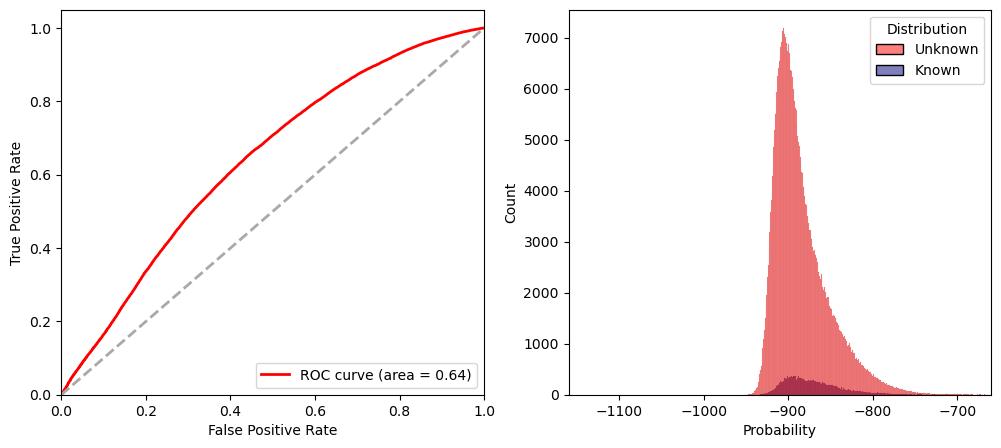

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# replace with file path
file_path = ''
roc(file_path, ax[0])
distro(file_path, ax[1])